# A simple parser for LTspice files

**Scott Prahl**

May 2022

This notebook treats files with op-amps LTspice files back to a simple netlist.

In [1]:
import matplotlib.pyplot as plt
import ltparser
import lcapy

# make matplotlib hires
%config InlineBackend.figure_format='retina'

In [2]:
print(lcapy.__version__)

1.26


W 1 2; right
W 3 4; right
W 5 6; right
W 1 7; down
W 8 7; right
W 7 9; right
W 4 10; down
W 11 10; right
W 10 12; right
W 13 14; right
W 5 15; down
W 13 16; down
W 17 0_1; down
W 18 0_2; down
R1 6 8 1000.0; right
R2 2 3 5000.0; right
R3 16 18 833.0; down
Vin 15 17 {Vin}; down
E1 11 0_3 opamp 9 14



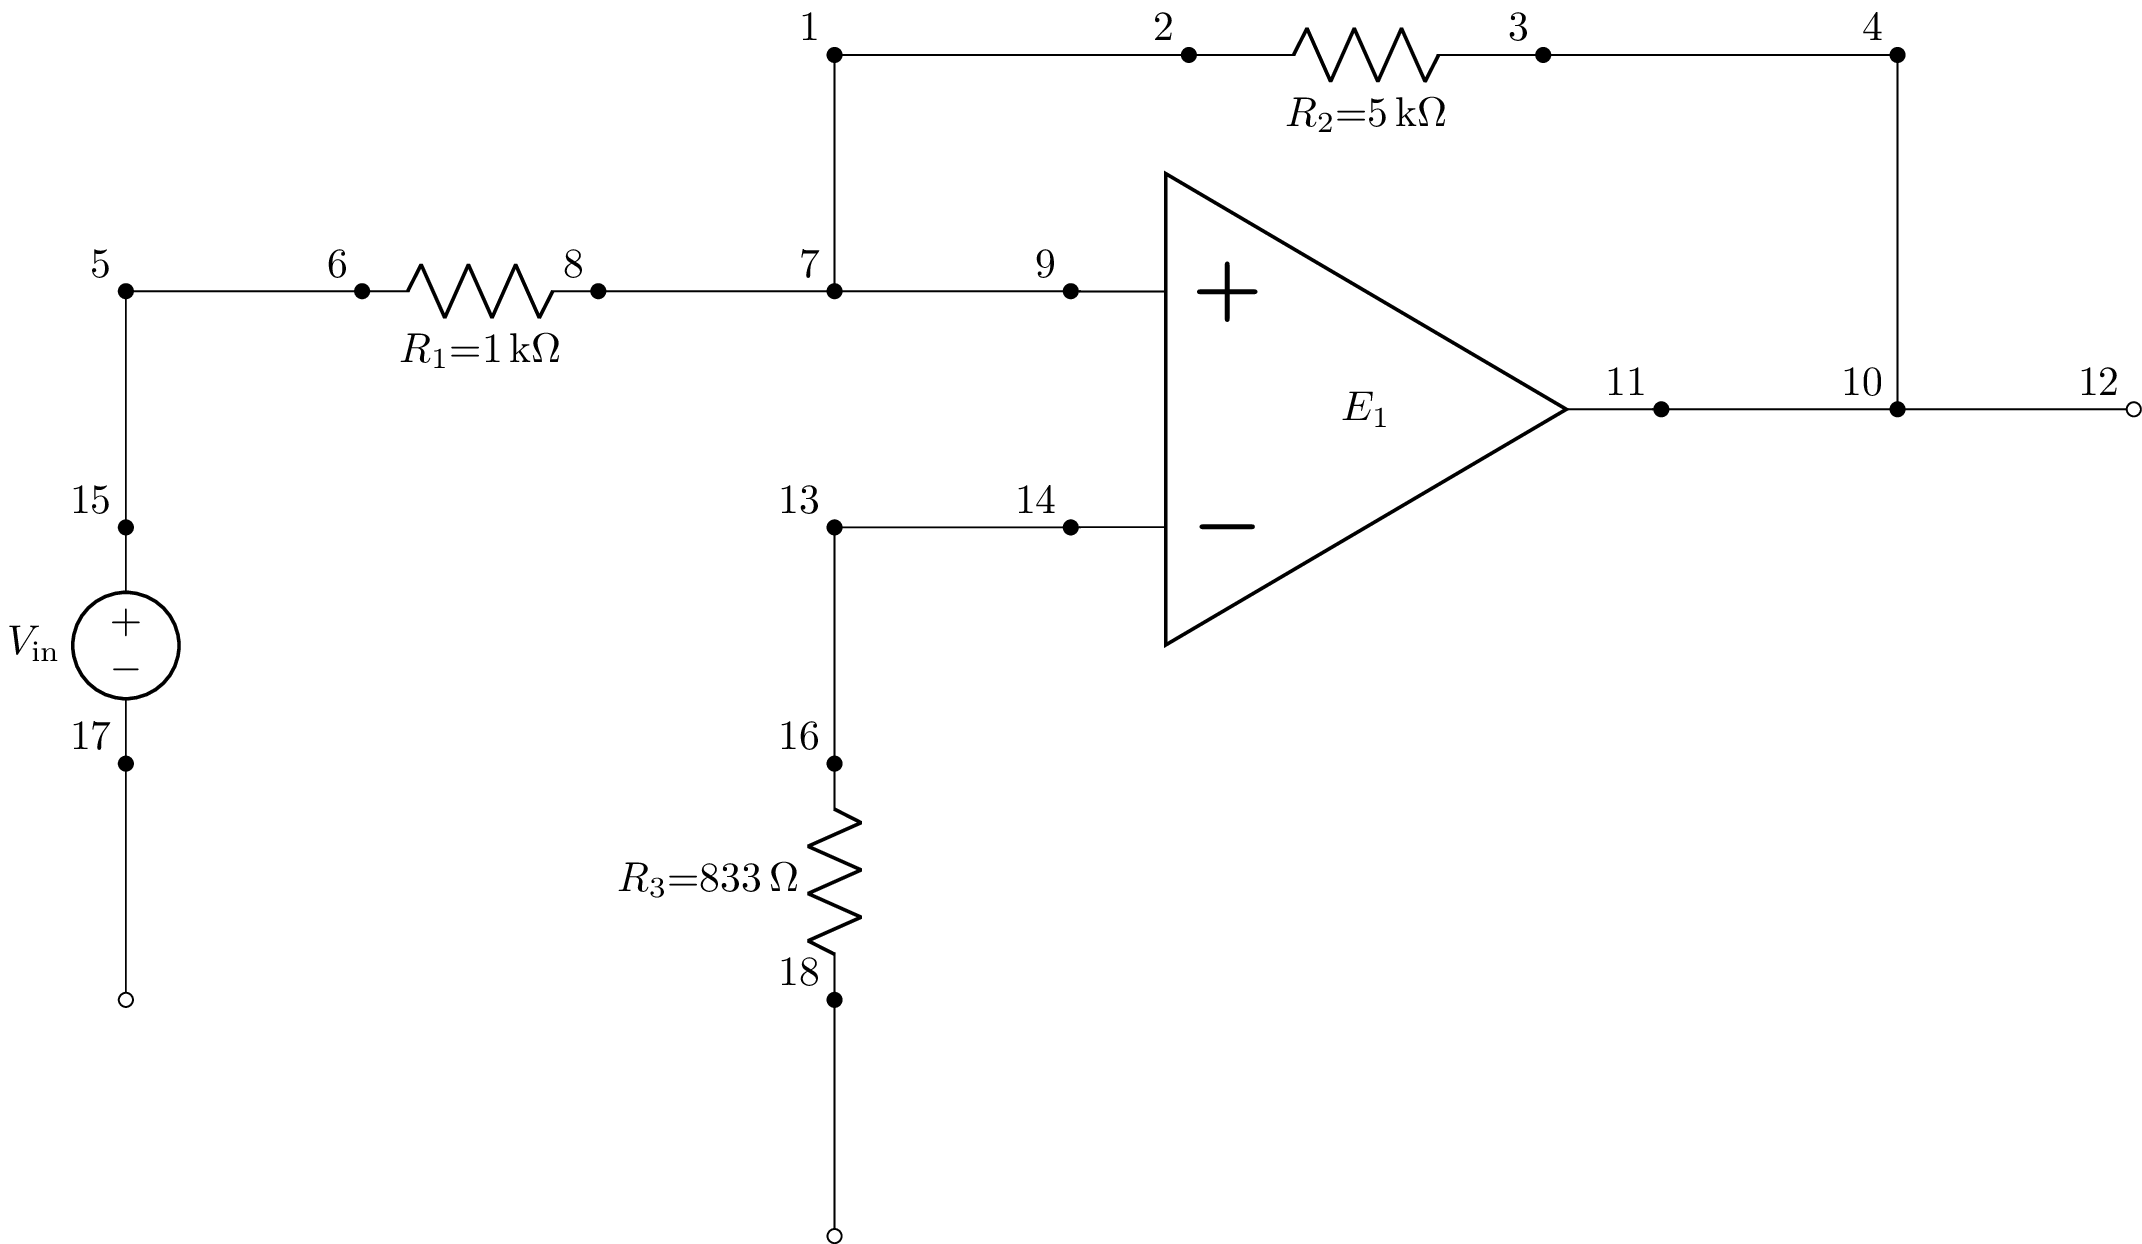

In [3]:
lt = ltparser.LTspice()
lt.read("../tests/examples/inverting-opamp-simple.asc")
lt.make_netlist()
print(lt.netlist)

# Should work now!
cct = lt.circuit()
cct.draw()

In [4]:
"""
Test drawing with net-extracted netlist.

This uses graph-based net extraction to ensure proper node connectivity.
"""

import ltparser  # Using ltparser_NET_EXTRACTION.py

print("=" * 70)
print("Testing Drawing with Net Extraction")
print("=" * 70)

# Parse circuit
print("\n1. Loading circuit...")
lt = ltparser.LTspice()
lt.read("../tests/examples/inverting-opamp-simple.asc")
lt.parse()
print("   ✅ Loaded")

# Generate netlist with NET EXTRACTION
print("\n2. Generating netlist with net extraction...")
lt.make_netlist(use_named_nodes=False, minimal=True, use_net_extraction=True)
print("   ✅ Generated")

print("\n3. Netlist:")
print("   " + "-" * 66)
for line in lt.netlist.splitlines():
    if line.strip():
        print(f"   {line}")
print("   " + "-" * 66)

# Analyze connectivity
print("\n4. Connectivity analysis:")
lines = [l for l in lt.netlist.splitlines() if l.strip()]
nodes_used = set()
for line in lines:
    parts = line.split()
    if len(parts) >= 3:
        # Extract node numbers
        for part in parts[1:]:
            if part.replace("-", "").isdigit():
                nodes_used.add(int(part))

print(f"   Unique nodes: {sorted(nodes_used)}")
print(f"   Node count: {len(nodes_used)}")
print(f"   Components: {len(lines)}")

# Create circuit
print("\n5. Creating lcapy circuit...")
try:
    cct = lt.circuit()
    print(f"   ✅ Circuit created")
    print(f"   Lcapy components: {len(cct.elements)}")
except Exception as e:
    print(f"   ❌ Failed: {e}")
    exit(1)

# Try to draw
print("\n6. Attempting to draw...")
try:
    cct.draw(scale=0.5, draw_nodes="connections")
    print("   ✅ DRAWING SUCCEEDED!")
    print("\n" + "=" * 70)
    print("🎉🎉🎉 SUCCESS! NET EXTRACTION WORKS! 🎉🎉🎉")
    print("=" * 70)
    print("\nThe circuit draws correctly because:")
    print("  • Net extraction identified electrical connections")
    print("  • Nodes were renumbered consistently")
    print("  • Components use the same node numbers when connected")
    print("  • Lcapy can now determine layout!")

except ValueError as e:
    error_str = str(e)
    print(f"   ❌ Drawing still failed")
    print(f"   Error: {error_str[:200]}")
    if "Cannot assign nodes" in error_str:
        print("\n   Still has layout issues. Possible causes:")
        print("   - Circuit is still too complex")
        print("   - Need additional layout hints")
        print("   - Lcapy version compatibility issue")
except Exception as e:
    print(f"   ❌ Unexpected error: {type(e).__name__}: {e}")

print("\n" + "=" * 70)

Testing Drawing with Net Extraction

1. Loading circuit...
   ✅ Loaded

2. Generating netlist with net extraction...
   ✅ Generated

3. Netlist:
   ------------------------------------------------------------------
   R1 1 2 1000.0
   R2 2 3 5000.0
   R3 4 0_1 833.0
   Vin 1 0_2 {Vin}
   E1 3 0_3 opamp 2 4
   ------------------------------------------------------------------

4. Connectivity analysis:
   Unique nodes: [1, 2, 3, 4]
   Node count: 4
   Components: 5

5. Creating lcapy circuit...
   ✅ Circuit created
   Lcapy components: 6

6. Attempting to draw...
   ❌ Unexpected error: RuntimeError: The vertical schematic graph has a loop.  For example, a node needs to be both above and below another node.  Probably a component is attached to the wrong nodes.




In [5]:
"""
Simple test to verify the solution works.

This tests ltparser_FINAL.py which has use_named_nodes=False as default.
"""

print("=" * 70)
print("Testing ltparser Drawing Solution")
print("=" * 70)

# Load circuit
lt = ltparser.LTspice()
lt.read("../tests/examples/inverting-opamp.asc")
lt.parse()

# Generate netlist with defaults
print("\n1️⃣  Generating netlist with default settings...")
lt.make_netlist()  # Should use use_named_nodes=False by default

# Analyze the netlist
print("\n2️⃣  Analyzing netlist...")
lines = lt.netlist.splitlines()
wire_lines = [l for l in lines if l.startswith("W")]
comp_lines = [l for l in lines if not l.startswith("W") and l.strip()]

print(f"   Total lines: {len(lines)}")
print(f"   Wire lines: {len(wire_lines)}")
print(f"   Component lines: {len(comp_lines)}")

# Check for issues
has_wires = len(wire_lines) > 0
has_named = any("+Vs" in l or "-Vs" in l or "Vout" in l for l in lines)

print(f"\n3️⃣  Validation:")
print(f"   ✅ Has wires: {has_wires}" if has_wires else f"   ❌ No wires found!")
print(
    f"   ✅ Named nodes converted: {not has_named}" if not has_named else f"   ❌ Named nodes still present!"
)

if not has_wires:
    print("\n❌ ERROR: No wires in netlist!")
    print("   Connectivity will be broken.")
    print("   Make sure you're using ltparser_FINAL.py")
    exit(1)

if has_named:
    print("\n❌ ERROR: Named nodes still present!")
    print("   Drawing will fail with layout errors.")
    print("   Named nodes found:")
    for line in lines:
        if "+Vs" in line or "-Vs" in line or "Vout" in line:
            print(f"     {line}")
    exit(1)

# Show sample
print("\n4️⃣  Sample of generated netlist (first 10 lines):")
for i, line in enumerate(lines[:10], 1):
    print(f"   {i:2d}. {line}")

# Try to load into lcapy
print("\n5️⃣  Loading circuit into lcapy...")
try:
    cct = lt.circuit()
    print(f"   ✅ Circuit loaded successfully")
    print(f"   Components: {len(cct.elements)}")
    print(f"   Nodes: {len(cct.node_list)}")
except Exception as e:
    print(f"   ❌ Failed to create circuit: {e}")
    exit(1)

# Try to draw
print("\n6️⃣  Attempting to draw...")
try:
    cct.draw(scale=0.5, draw_nodes="connections", label_nodes=False)
    print("   ✅ Drawing succeeded!")

    print("\n" + "=" * 70)
    print("🎉 SUCCESS! Everything works!")
    print("=" * 70)
    print("\nThe solution:")
    print("  • Wires preserved (connectivity ✅)")
    print("  • Named nodes converted to numbers (layout ✅)")
    print("  • Op-amp support included ✅")
    print("  • Drawing works! ✅")

except ValueError as e:
    error_str = str(e)
    if "Cannot assign nodes" in error_str:
        print(f"   ❌ Drawing failed with layout error")
        print(f"\n   Error message (truncated):")
        print(f"   {error_str[:200]}...")
        print("\n   This usually means named nodes are still in the netlist.")
        print("   Make sure use_named_nodes=False is the default in your ltparser.py")
    else:
        print(f"   ❌ Drawing failed: {error_str[:100]}...")
except Exception as e:
    print(f"   ❌ Unexpected error: {e}")
    import traceback

    traceback.print_exc()

print("\n" + "=" * 70)

Testing ltparser Drawing Solution

1️⃣  Generating netlist with default settings...

2️⃣  Analyzing netlist...
   Total lines: 29
   Wire lines: 22
   Component lines: 7

3️⃣  Validation:
   ✅ Has wires: True
   ✅ Named nodes converted: True

4️⃣  Sample of generated netlist (first 10 lines):
    1. W 1 2; right
    2. W 3 4; right
    3. W 5 6; down
    4. W 5 7; down
    5. W 8 9; right
    6. W 1 10; down
    7. W 11 10; right
    8. W 10 12; right
    9. W 4 13; down
   10. W 14 13; right

5️⃣  Loading circuit into lcapy...
   ✅ Circuit loaded successfully
   Components: 30
   Nodes: 9

6️⃣  Attempting to draw...
   ❌ Drawing failed with layout error

   Error message (truncated):
   Cannot assign nodes [('5', '6', '7', '18', '19', '24', '26', '22', '23'), ('20', '0_1')] for horizontal graph.
@3.0 (1, 10) --1.0*--> (2)
@3.0 (1, 10) --1.0*--> (17, 12)
@2.0 (2) --1.0*--> (3)
@1.0 (3...

   This usually means named nodes are still in the netlist.
   Make sure use_named_nodes=False is 

In [6]:
lt = ltparser.LTspice()
lt.read("../tests/examples/inverting-opamp.asc")
print(lt.contents)
lt.make_netlist()
print(lt.netlist)
lt.plot_nodes()

Version 4
SHEET 1 880 680
WIRE 464 128 288 128
WIRE 624 128 544 128
WIRE -208 176 -208 144
WIRE 368 208 368 176
WIRE 80 224 -16 224
WIRE 288 224 288 128
WIRE 288 224 160 224
WIRE 336 224 288 224
WIRE 624 240 624 128
WIRE 624 240 400 240
WIRE 688 240 624 240
WIRE 336 256 176 256
WIRE -208 288 -208 256
WIRE -128 288 -208 288
WIRE -16 288 -16 224
WIRE 368 304 368 272
WIRE -208 320 -208 288
WIRE -128 320 -128 288
WIRE 176 352 176 256
WIRE -208 448 -208 400
WIRE -16 464 -16 368
WIRE 176 464 176 432
FLAG -128 320 0
FLAG -208 448 -Vs
FLAG -208 144 +Vs
FLAG 368 176 +Vs
FLAG 368 304 -Vs
FLAG 688 240 Vout
IOPIN 688 240 Out
FLAG 176 464 0
FLAG -16 464 0
SYMBOL Opamps/UniversalOpamp2 368 240 R0
SYMATTR InstName U1
SYMBOL res 176 208 R90
WINDOW 0 0 56 VBottom 2
WINDOW 3 32 56 VTop 2
SYMATTR InstName R1
SYMATTR Value 1k
SYMBOL res 560 112 R90
WINDOW 0 0 56 VBottom 2
WINDOW 3 32 56 VTop 2
SYMATTR InstName R2
SYMATTR Value 5k
SYMBOL res 192 448 R180
WINDOW 0 36 76 Left 2
WINDOW 3 36 40 Left 2
SYMATTR 

ValueError: not enough values to unpack (expected 2, got 1)

<Figure size 1400x600 with 0 Axes>

In [ ]:
lt.parse()
lt.make_netlist()
print(lt.netlist)
lt.plot_nodes()

In [ ]:
cct = lt.circuit()
cct.draw(scale=0.5)

In [ ]:
lt = ltparser.LTspice()
lt.read("../tests/examples/audio-crossover2.asc")
lt.make_netlist()
lt.plot_nodes()
print(lt.netlist)

In [ ]:
cct = lt.circuit()
cct.draw(scale=0.5)

### Audio Cross-over

here is a simple audio crossover

<img src="images/audio_crossover.png" width=100%>

In [ ]:
lt = ltparser.LTspice()
lt.read("../tests/examples/audio-crossover.asc")
lt.make_netlist()
lt.plot_nodes()
print(lt.netlist)
cct = lt.circuit()
cct.draw(scale=0.5)

In [ ]:
import imageio

im = imageio.imread("../tests/examples/audio-crossover.png")
plt.figure(figsize=(14, 6))
plt.imshow(im)
plt.show()

In [ ]:
print(lt.netlist)

In [ ]:
lt.make_graph()

In [ ]:
cct = lt.circuit()
cct.draw(scale=0.5)